
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We will pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages

In [2]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition


import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [3]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train') #, data_home = '~/shared/sklearnData'
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [4]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [5]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'])#, data_home = '~/shared/sklearnData'
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,"""auto\nfrom"
4,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,/Users/jevans/scikit_learn_data/20news_home/20...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [7]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [8]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [9]:
newsgroupsVects[:10,:20].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [10]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [11]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [12]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.046688020755456),
 ('certain', 0.1589865268627092),
 ('apple', 0.22685454684169398),
 ('13', 0.14113625048015269),
 ('rgb', 0.1817286448065436),
 ('monitors', 0.16194122924300089),
 ('there', 0.074956903065618502),
 ('has', 0.074842993100868407),
 ('been', 0.095991006908172),
 ('problem', 0.18819404816424326),
 ('with', 0.054640923210934937),
 ('the', 0.1109950967372947),
 ('high', 0.12601141569529475),
 ('voltage', 0.19706119834212132),
 ('capasitor', 0.24220644191410201),
 ('knows', 0.16299450361806797),
 ('about', 0.15540750198460515),
 ('this', 0.057498781219299681),
 ('and', 0.04330392033255178),
 ('is', 0.04793741654764163)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [13]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix:

In [15]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

The matrix is much smaller now, only 5000 words, but the same number of documents

We can still look at the words:

In [16]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with K-means

Lets start with k-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [17]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [20]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [21]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few.

In [22]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("for our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_curve', 'precision_recall_fsc

We can also look at the contents of the clusters:

In [23]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 mac
 thanks
 just
 does
 drive
 apple
 like
 don
 new


Cluster 1:
 sale
 00
 offer
 shipping
 condition
 asking
 new
 interested
 sell
 price


Cluster 2:
 car
 cars
 engine
 like
 just
 good
 think
 don
 oil
 dealer


Cluster 3:
 window
 server
 use
 motif
 using
 program
 widget
 application
 like
 code




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [24]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())

In [25]:
reduced_data = pca.transform(newsgroupsTFVects.toarray())
components = pca.components_

In [26]:
keyword_ids = list(set(order_centroids[:,:10].flatten()))
words = [terms[i] for i in keyword_ids]
x = components[:,keyword_ids][0,:]
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [27]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

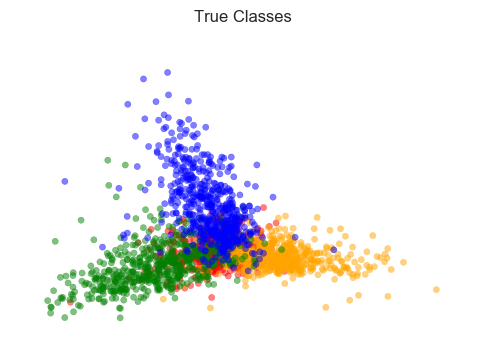

In [28]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also construct a biplot and map our feature
vectors to the same space.

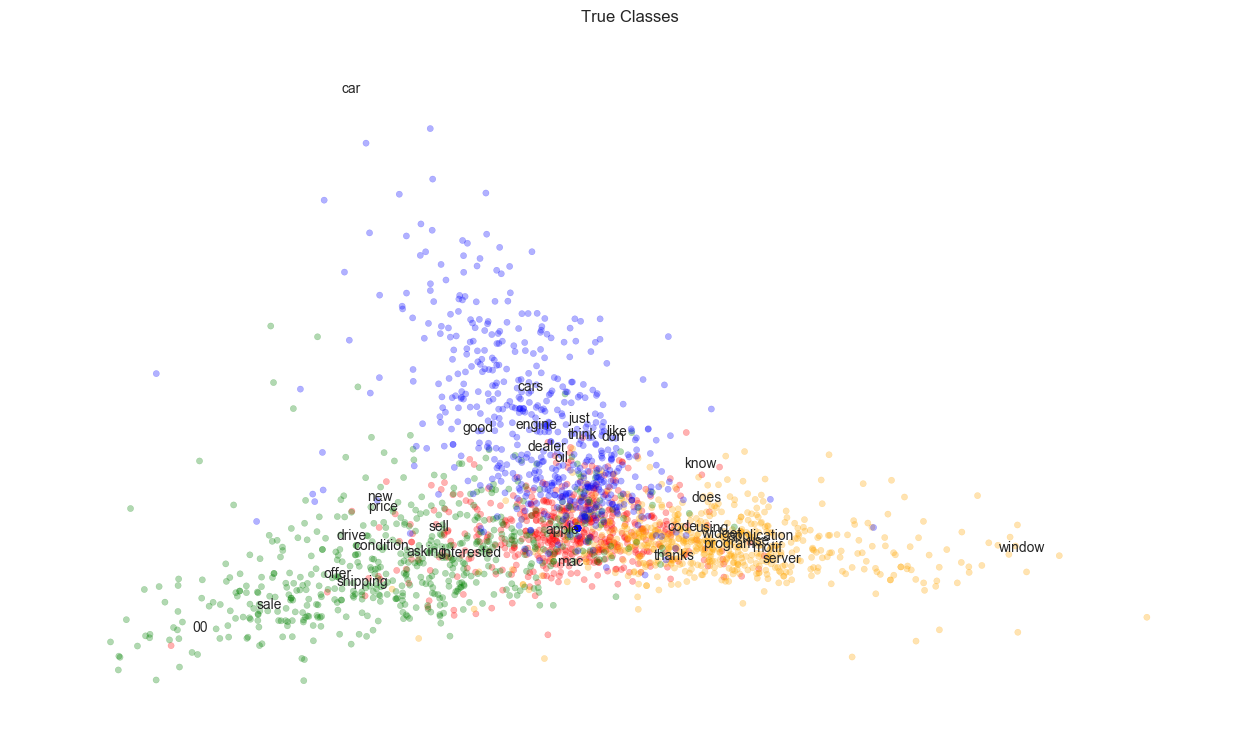

In [29]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's visualize this once again with predicted clusters.

In [30]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

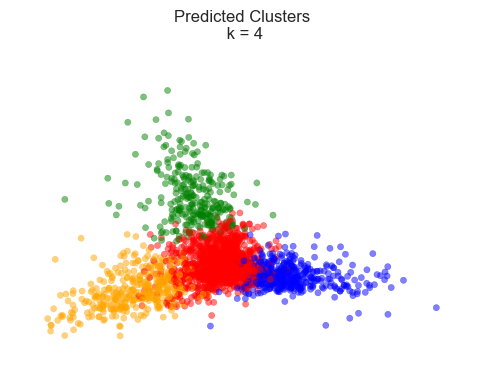

In [31]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Now let's try clustering these newsgroups with 3 clusters.

In [32]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

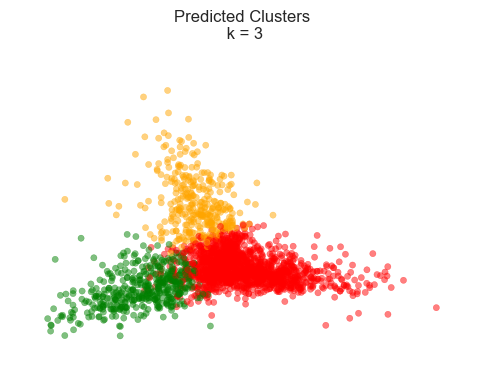

In [33]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km3.labels_]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Plot the clusters and features after reducing with PCA. What does this cluster structure reveal about the structure of documents in your corpora? 

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [35]:

newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the first 100 texts.

In [36]:
linkage_matrix = scipy.cluster.hierarchy.ward(newsgroupsCoocMat[:100, :100].toarray())
linkage_matrix[:10]

array([[   3.        ,   26.        ,    0.        ,    2.        ],
       [  52.        ,  100.        ,    0.        ,    3.        ],
       [  68.        ,  101.        ,    0.        ,    4.        ],
       [  75.        ,  102.        ,    0.        ,    5.        ],
       [  76.        ,  103.        ,    0.        ,    6.        ],
       [  82.        ,  104.        ,    0.        ,    7.        ],
       [  99.        ,  105.        ,    0.        ,    8.        ],
       [  71.        ,   97.        ,    0.28035552,    2.        ],
       [  22.        ,   55.        ,    0.28134893,    2.        ],
       [  21.        ,  107.        ,    0.31355623,    3.        ]])

Now we can visualize the tree

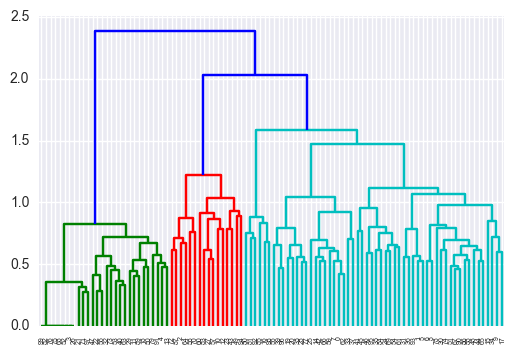

In [37]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

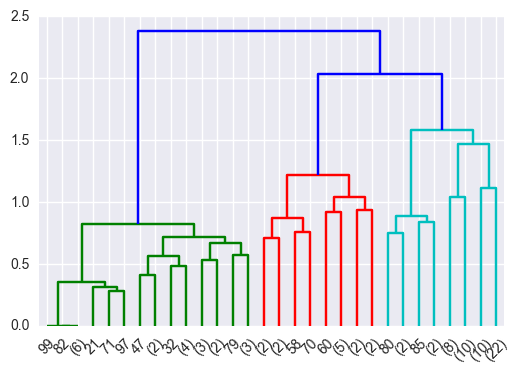

In [38]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level')

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters

In [39]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 2, 1, 2, 1, 4, 4, 3, 4, 1, 4, 4, 1, 1,
       2, 4, 4, 1, 2, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4,
       4, 1, 4, 2, 1, 4, 1, 1, 4, 1, 4, 2, 2, 4, 2, 4, 4, 1, 2, 4, 4, 4, 1,
       4, 2, 1, 2, 1, 4, 1, 1, 4, 4, 1, 3, 3, 1, 2, 4, 3, 4, 2, 4, 1, 4, 1,
       3, 4, 2, 4, 4, 1, 3, 1], dtype=int32)

This gives us an array giving each element of `linkage_matrix`'s cluster. We can save this, plot it or look for representative examples from the clusters.

In [40]:
clusterLeaders = scipy.cluster.hierarchy.leaders(linkage_matrix, hierarchicalClusters)
clusterLeaders

(array([183, 195, 194, 178], dtype=int32), array([3, 4, 2, 1], dtype=int32))

We can then look these up in our original data

In [35]:
newsgroupsDF.iloc[clusterLeaders[0]]

,category,source_file,text
183,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nEven the 68000 can fetch two bytes at a ti...
195,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Hi all:\nDoes anyone know where I can get the ...
194,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Here is the story:\nI have a network with 4 Ma...
178,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\nWell Bill, There are 2MB soldered on the log..."


## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the structure of documents in your corpora? 

# Gensim

To do topic modeling we will again be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). Lets start by defining the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [41]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)

    #Check for rate limiting
    if r.status_code != 200:
        raise RuntimeError("Github didn't like your request, you have probably been rate limited.")
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

targetSenators = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']

"""
senReleasesTraining = pandas.DataFrame()

for senator in targetSenators:
    print("Fetching {}'s data".format(senator))
    targetDF = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(senator), maxFiles = 100)
    targetDF['senator'] = senator
    senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""
senReleasesTraining = pandas.DataFrame.from_csv("data/senReleasesTraining.csv")

senReleasesTraining[::100]

,download_url,html_url,name,path,text,senator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Voinovich3.txt,raw/Voinovich/10Apr2008Voinovich3.txt,SEN. VOINOVICH SECURES ASSISTANCE FOR STRUGGLI...,Voinovich
100,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
200,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,Whitehouse
300,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Snowe403.txt,raw/Snowe/10Apr2006Snowe403.txt,"SEN. SNOWE, SENATE FINANCE COMMITTEE MEMBERS U...",Snowe
400,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Rockefeller210.txt,raw/Rockefeller/10Apr2006Rockefeller210.txt,SEN. ROCKEFELLER DEMANDS THAT CHINA PLAY FAIR ...,Rockefeller
500,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Feb2006Murkowski158.txt,raw/Murkowski/10Feb2006Murkowski158.txt,SEN. MURKOWSKI PRAISES EXTENSION OF FMAP MATCH...,Murkowski
600,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,.Rapp.history,raw/McCain/.Rapp.history,"edu_mat<- matrix(0, nrow=3, ncol=2)#\ndiag(edu...",McCain
700,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Kyl232.txt,raw/Kyl/10Apr2006Kyl232.txt,WE NEED SENSIBLE IMMIGRATION REFORM\n Last we...,Kyl
800,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Baucus15.txt,raw/Baucus/10Aug2005Baucus15.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPres...,Baucus
900,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Frist268.txt,raw/Frist/10Apr2006Frist268.txt,SEN. FRIST'S CHIEF OF STAFF CALLS FOR FAIR PRO...,Frist


Now we have the files we can tokenize and normalize

In [42]:
#Define the same function as last week
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

senReleasesTraining[::100]

,download_url,html_url,name,path,text,senator,tokenized_text,normalized_tokens
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Voinovich3.txt,raw/Voinovich/10Apr2008Voinovich3.txt,SEN. VOINOVICH SECURES ASSISTANCE FOR STRUGGLI...,Voinovich,"[SEN., VOINOVICH, SECURES, ASSISTANCE, FOR, ST...","[voinovich, secur, assist, struggl, homeown, e..."
100,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama,"[Obama, Calls, on, IRS, to, Protect, Taxpayers...","[obama, call, ir, protect, taxpay, privaci, u,..."
200,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,Whitehouse,"[SEN., WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S,...","[whitehous, share, wester, girl, stori, push, ..."
300,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Snowe403.txt,raw/Snowe/10Apr2006Snowe403.txt,"SEN. SNOWE, SENATE FINANCE COMMITTEE MEMBERS U...",Snowe,"[SEN., SNOWE, ,, SENATE, FINANCE, COMMITTEE, M...","[snow, senat, financ, committe, member, urg, c..."
400,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Rockefeller210.txt,raw/Rockefeller/10Apr2006Rockefeller210.txt,SEN. ROCKEFELLER DEMANDS THAT CHINA PLAY FAIR ...,Rockefeller,"[SEN., ROCKEFELLER, DEMANDS, THAT, CHINA, PLAY...","[rockefel, demand, china, play, fair, trade, j..."
500,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Feb2006Murkowski158.txt,raw/Murkowski/10Feb2006Murkowski158.txt,SEN. MURKOWSKI PRAISES EXTENSION OF FMAP MATCH...,Murkowski,"[SEN., MURKOWSKI, PRAISES, EXTENSION, OF, FMAP...","[murkowski, prais, extens, fmap, match, rate, ..."
600,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,.Rapp.history,raw/McCain/.Rapp.history,"edu_mat<- matrix(0, nrow=3, ncol=2)#\ndiag(edu...",McCain,"[edu_mat, <, -, matrix, (, 0, ,, nrow=3, ,, nc...","[matrix, diag, matrix, matrix, diag, matrix, d..."
700,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Kyl232.txt,raw/Kyl/10Apr2006Kyl232.txt,WE NEED SENSIBLE IMMIGRATION REFORM\n Last we...,Kyl,"[WE, NEED, SENSIBLE, IMMIGRATION, REFORM, Last...","[need, sensibl, immigr, reform, last, week, se..."
800,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Baucus15.txt,raw/Baucus/10Aug2005Baucus15.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPres...,Baucus,"[Press, Release, :, PRESIDENT, SIGNS, HIGHWAY,...","[press, releas, presid, sign, highway, bill, p..."
900,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2006Frist268.txt,raw/Frist/10Apr2006Frist268.txt,SEN. FRIST'S CHIEF OF STAFF CALLS FOR FAIR PRO...,Frist,"[SEN., FRIST, 'S, CHIEF, OF, STAFF, CALLS, FOR...","[frist, chief, staff, call, fair, process, imm..."


To use the texts with gensim we need to create a `corpua` object. This takes a few steps. First we create a `Dictioanry` that maps tokens to ids.

In [43]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['normalized_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [45]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['normalized_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [46]:
gensim.corpora.MmCorpus.serialize('data/senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('data/senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [47]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10)

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [49]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['normalized_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of text {}".format(senReleasesTraining['name'][0]))
print("are {}".format(sen1lda))

The topics of text 10Apr2008Voinovich3.txt
are [(2, 0.67756138945431266), (3, 0.32032169194540422)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [50]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['normalized_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [51]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,10Apr2008Voinovich4.txt,"[(3, 0.313741039611), (7, 0.683359661969)]",0.000000,0.000000,0.000000,0.313741,0.000000,0.000000,0.000000,0.683360,0.000000,0.000000
101,10Apr2008Obama108.txt,"[(0, 0.302044529499), (3, 0.646438344802), (8,...",0.302045,0.000000,0.000000,0.646438,0.000000,0.000000,0.000000,0.000000,0.048167,0.000000
201,10Apr2008Whitehouse2.txt,"[(1, 0.994609314674)]",0.000000,0.994609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
301,10Apr2006Snowe404.txt,"[(7, 0.992305803947)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992306,0.000000,0.000000
401,10Apr2008Rockefeller5.txt,"[(2, 0.996895745648)]",0.000000,0.000000,0.996896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
501,10Jan2007Murkowski97.txt,"[(5, 0.996497348275)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.996497,0.000000,0.000000,0.000000,0.000000
601,01Aug2006McCain71.txt,"[(3, 0.252463531408), (4, 0.118504278447), (8,...",0.000000,0.000000,0.000000,0.252464,0.118504,0.000000,0.000000,0.000000,0.624236,0.000000
701,10Aug2007Kyl74.txt,"[(4, 0.985479879366)]",0.000000,0.000000,0.000000,0.000000,0.985480,0.000000,0.000000,0.000000,0.000000,0.000000
801,10Jan2007Baucus62.txt,"[(0, 0.366682976524), (1, 0.404472056469), (2,...",0.366683,0.404472,0.109378,0.000000,0.000000,0.000000,0.026964,0.000000,0.073040,0.019074
901,10Aug2004Frist346.txt,"[(4, 0.980430074811)]",0.000000,0.000000,0.000000,0.000000,0.980430,0.000000,0.000000,0.000000,0.000000,0.000000


We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [52]:
senlda.show_topic(1)

[('senat', 0.010173703784646278),
 ('presid', 0.0085759969299137057),
 ('would', 0.0077281529689686287),
 ('state', 0.0070811496963434552),
 ('american', 0.0052789850424710787),
 ('program', 0.0052176801373180048),
 ('iraq', 0.0047404417485033701),
 ('secur', 0.0044184927995715023),
 ('legisl', 0.0043054191157905052),
 ('nation', 0.0042370115582733188)]

And if we want to make a `dataFrame`:

In [53]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,senat,senat,senat,senat,bill,senat,senat,senat,senat,health
1,bill,presid,state,bill,senat,state,said,nation,state,senat
2,would,would,would,nation,would,bill,state,state,provid,said
3,year,state,fund,year,state,nation,year,said,today,baucus
4,act,american,bill,program,help,year,baucus,bill,secur,state
5,nation,program,today,fund,secur,today,program,fund,nation,care
6,american,iraq,provid,tax,z,legisl,would,new,would,nation
7,provid,secur,year,state,said,would,fund,program,year,program
8,tax,legisl,presid,said,committe,said,million,provid,legisl,k
9,program,nation,work,today,today,tax,health,legisl,bill,american


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents?

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 